# Tutorial 10 - Clustering

### Lecture and Tutorial Learning Goals:

After completing this week's lecture and tutorial work, you will be able to:

* Describe a case where clustering would be an appropriate tool, and what insight it would bring from the data.
* Explain the k-means clustering algorithm.
* Interpret the output of a k-means cluster analysis.
* Perform k-means clustering in R using `k-means`
* Visualize the output of k-means clustering in R using a coloured scatter plot 
* Identify when it is necessary to scale variables before clustering and do this using R
* Use the elbow method to choose the number of clusters for k-means
* Describe advantages, limitations and assumptions of the kmeans clustering algorithm.

In [2]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(GGally)
library(broom)
options(repr.matrix.max.rows = 6)
source('tests.R')
source("cleanup.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘testthat’


The following object is masked from ‘package:dplyr’:

    matches


The following object is masked from ‘package:purrr’:

    is_null


The following objects are masked from ‘package:readr’:

    edition_get, local_edition


The following object is masked from ‘package:tidyr’:

    matches




# 1. Pokemon

We will be working with the Pokemon dataset from Kaggle, which can be found [here.](https://www.kaggle.com/abcsds/pokemon)
This dataset compiles the statistics on 721 Pokemon. The information in this dataset includes Pokemon name, type, health points, attack strength, defensive strength, speed points etc. These are values that apply to a Pokemon's abilities (higher values are better). We are interested in seeing if there are any sub-groups/clusters of pokemon based on these statistics. And if so, how many sub-groups/clusters there are.

![](https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif)

Source: https://media.giphy.com/media/3oEduV4SOS9mmmIOkw/giphy.gif


**Question 1.0**
<br> {points: 1}

Use `read_csv` to load `pokemon.csv` from the `data/` folder.

*Assign your answer to an object called `pm_data`.*

In [3]:
# your code here
pm_data <- read_csv("data/pokemon.csv")
pm_data

Rows: 800 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Name, Type 1, Type 2
dbl (9): #, Total, HP, Attack, Defense, Sp. Atk, Sp. Def, Speed, Generation
lgl (1): Legendary

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,TRUE
720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,TRUE
721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,TRUE


In [4]:
test_1.0()

Test passed 😀
Test passed 🥇
Test passed 🥳
Test passed 🥇
[1] "Success!"


**Question 1.1**
<br> {points: 1}

Create a matrix of plots using `ggpairs`, choosing columns 5 to 11 (or equivalently, columns `Total` to `Speed`) from `pm_data`. First use the `select` function to extract columns `"Total":"Speed"`, and then pass the resulting dataframe to `ggpairs` to plot.

*Assign your answer to an object called `pm_pairs`.*

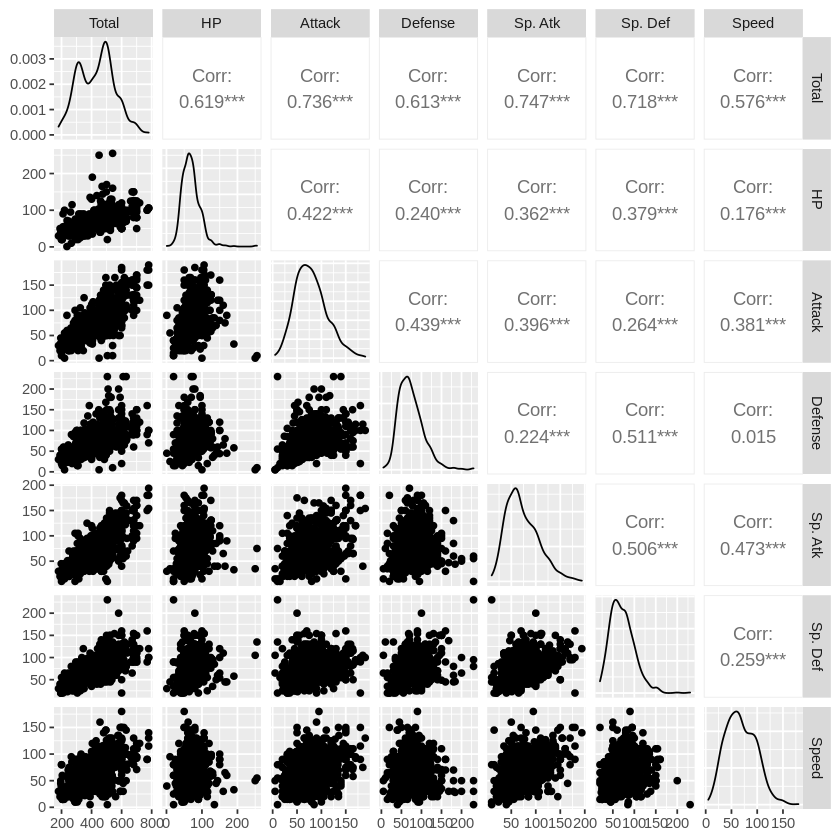

In [5]:
# your code here
pm_selected <- pm_data |>
    select("Total":"Speed")
pm_pairs <- ggpairs(pm_selected)
pm_pairs

In [6]:
test_1.1()

Test passed 🥇
Test passed 😀
Test passed 🎊
Test passed 🥇
[1] "Success!"


**Question 1.2** 
<br> {points: 1}

Select the columns `Speed` and `Defense`, creating a new dataframe with only those columns.

*Assign your answer to an object named `km_data`.*

In [7]:
# your code here
km_data <- pm_selected |>
    select("Speed", "Defense")
km_data

Speed,Defense
<dbl>,<dbl>
45,49
60,63
80,83
⋮,⋮
70,60
80,60
70,120


In [8]:
test_1.2()

Test passed 🌈
Test passed 😸
[1] "Success!"


**Question 1.3**
<br> {points: 1}

Make a scatterplot to visualize the relationship between `Speed` and `Defense` of the Pokemon. Put the `Speed` variable on the x-axis, and the `Defense` variable on the y-axis.

*Assign your plot to an object called `pm_scatter`. Don't forget to do everything needed to make an effective visualization.*

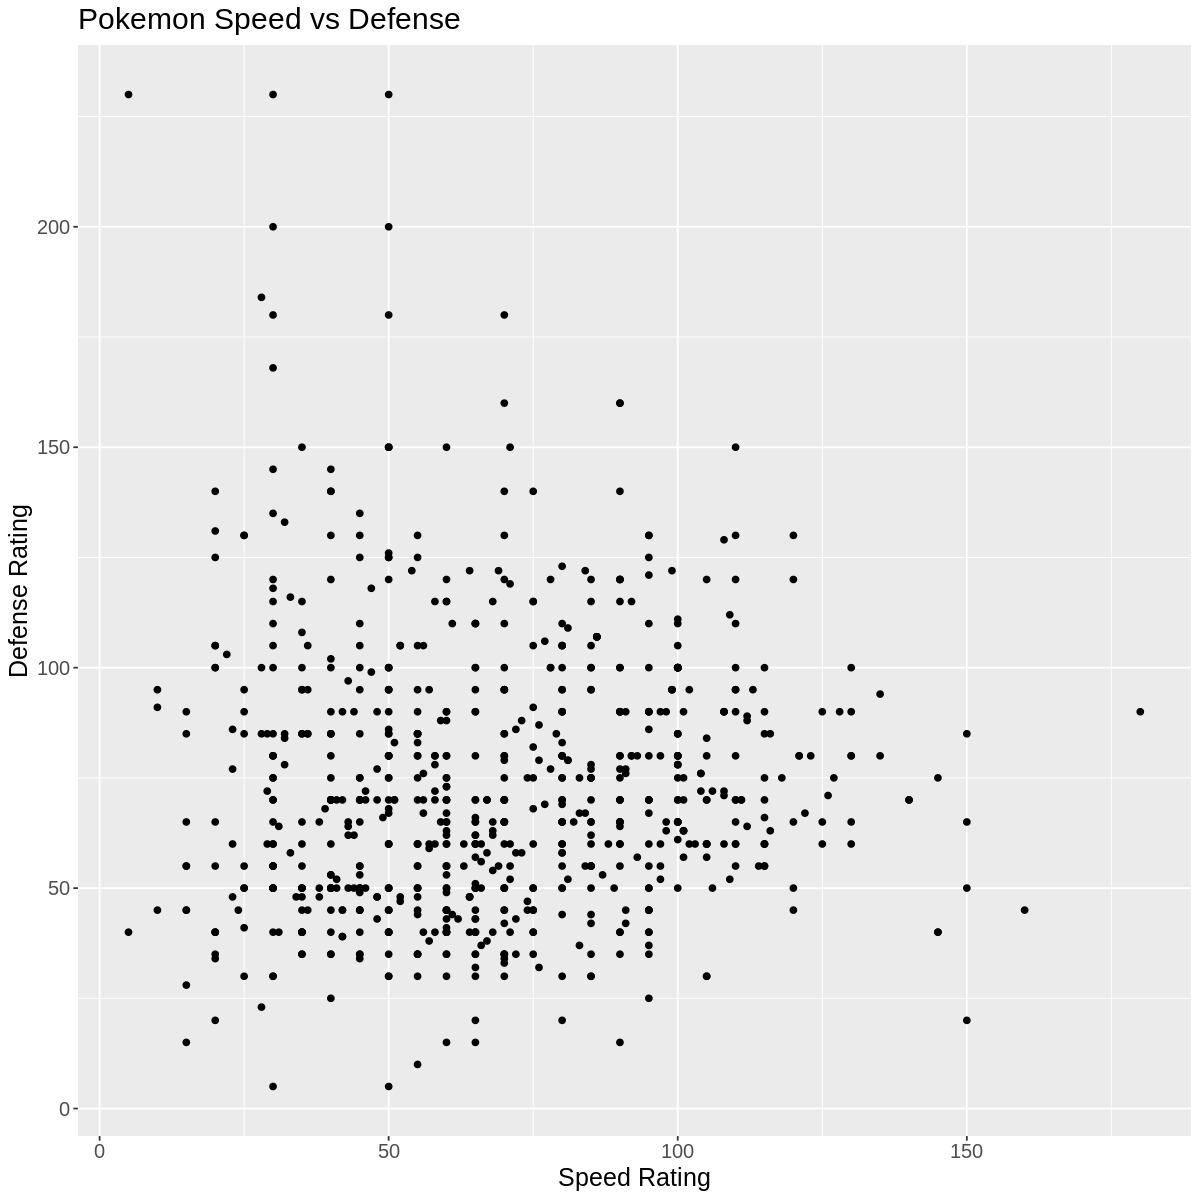

In [9]:
# your code here
options(repr.plot.width = 10, repr.plot.height = 10) 
pm_scatter <- ggplot(km_data, aes(x = Speed, y = Defense)) +
    geom_point() +
    labs(x = 'Speed Rating', y = 'Defense Rating') +
    theme(text = element_text(size = 15)) +
    ggtitle('Pokemon Speed vs Defense')
pm_scatter

In [10]:
test_1.3()

Test passed 🥳
Test passed 😀
Test passed 🥇
Test passed 🥳
Test passed 🎉
[1] "Success!"


**Question 1.4.1** 
<br> {points: 3}

We are going to cluster the Pokemon based on their `Speed` and `Defense`. Will it matter much for our clustering if we scale our variables? Is there any argument against scaling here?

Yes it does matter for our clustering if we scale our variables. Much like knn algorithms for classification and regression, clustering uses straight line distances between points to decide which points to cluster. This means that variables with a larger scale will have a larger effect on point clusters as apposed to smaller scale variables. We would scale this data to guarantee that Defense doesn't influence clustering more than speed does. The argument against scaling would be that there isn't a noticable disparity in the scaling of the variables, as they are very similar. Scaling the data adds an extra step, and also makes the visualizations more difficult to interpret.

**Question 1.4.2**
<br> {points: 1}

Now, let's use the `kmeans` function to cluster the Pokemon based on their `Speed` and `Defense` variables. For this question, use $k$ = 4. As good practice, let's standardize the data here first using `scale`. Name the standardized data `scaled_km_data`.

*Assign your answer to an object called `pokemon_clusters`.*

**Note:** We set the random seed here because `kmeans` initializes observations to random clusters.

In [11]:
#DON'T CHANGE THE SEED VALUE BELOW!
set.seed(2019)

# your code here
scaled_km_data <- km_data |>
    map_df(scale)
pokemon_clusters <- scaled_km_data |>
    kmeans(center = 4)
pokemon_clusters

K-means clustering with 4 clusters of sizes 259, 180, 99, 262

Cluster means:
       Speed     Defense
1 -0.5486990 -0.89261236
2 -0.7505326  0.31771609
3 -0.1256427  1.86306518
4  1.1055250 -0.03986927

Clustering vector:
  [1] 1 1 4 3 1 4 4 4 4 2 2 3 3 1 1 1 1 1 1 4 1 1 4 4 1 4 1 4 1 4 4 4 2 3 1 2 4
 [38] 1 1 4 1 2 1 4 1 1 1 4 1 2 2 1 2 1 4 4 4 4 4 1 4 1 4 1 4 4 4 2 1 4 4 4 1 2
 [75] 2 1 1 1 1 4 2 2 3 4 4 2 2 3 2 2 1 1 4 1 2 1 2 2 3 1 4 4 4 3 1 2 2 3 4 4 2
[112] 2 2 2 4 4 2 2 3 2 3 1 3 4 4 2 4 1 1 4 4 4 4 4 4 4 4 3 4 4 4 3 2 1 1 1 4 1
[149] 2 2 3 2 3 4 4 2 4 4 4 1 1 4 4 4 4 4 2 2 4 1 4 4 2 2 3 1 4 1 1 1 4 1 2 4 1
[186] 1 1 1 1 2 2 1 4 1 1 2 2 2 1 2 2 2 1 1 4 4 1 1 4 1 2 4 3 4 2 4 1 1 4 2 3 2
[223] 3 3 3 1 2 4 2 3 3 4 3 4 1 2 1 3 1 2 2 1 2 1 2 3 1 4 4 4 1 3 2 4 1 1 2 1 4
[260] 1 4 1 4 4 3 1 2 3 3 3 4 4 1 4 4 4 1 1 4 4 1 2 2 3 1 2 1 4 1 1 1 1 2 1 1 2
[297] 1 1 4 1 4 1 2 1 1 4 4 1 1 1 2 1 4 4 2 4 1 1 1 1 1 1 1 3 1 1 2 3 2 3 2 3 3
[334] 3 1 4 4 1 4 4 4 4 4 4 1 1 2 1 4 4 1 1 1 2 2 3 1 4 1

In [12]:
test_1.4.2()

Test passed 🥇
Test passed 😀
Test passed 🎊
[1] "Success!"


**Question 1.5**
<br> {points: 1}

Let's visualize the clusters we built in `pokemon_clusters`. For this we can use the `broom` package.

> "The broom package takes the messy output of built-in functions in R, such as lm, nls, or t.test, and turns them into tidy data frames." - [Broom Package](https://cran.r-project.org/web/packages/broom/vignettes/broom.html)

Your tasks:

1. Use the `augment` function create a data frame with the cluster assignments for each data point from k-means (should have the columns `Speed` and `Defense` and `.cluster`). 
2. Create a scatter plot of `Speed` (x-axis) vs `Defense` (y-axis) with the points coloured by their cluster assignment. 

Name this plot `answer1.5`.

Speed,Defense,.cluster
<dbl>,<dbl>,<fct>
45,49,1
60,63,1
80,83,4
⋮,⋮,⋮
70,60,1
80,60,4
70,120,3


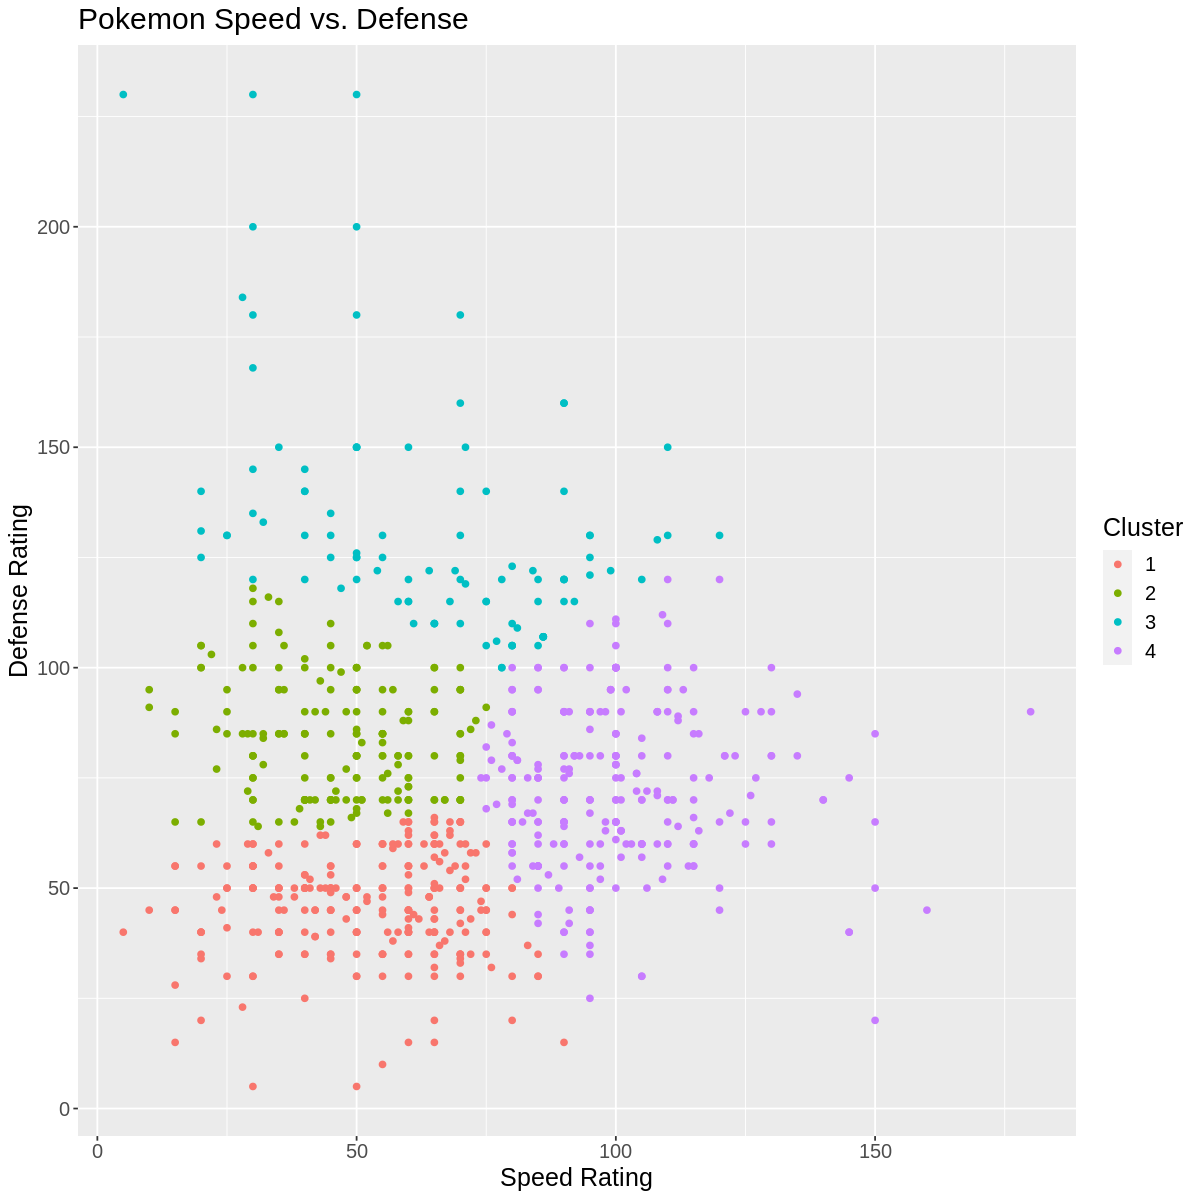

In [13]:
# your code here
clusters2 <- augment(pokemon_clusters, km_data)
clusters2
options(repr.plot.width = 10, repr.plot.height = 10) 
answer1.5 <- ggplot(clusters2, aes(x = Speed, y = Defense, colour = .cluster)) +
    geom_point() +
    labs(x = 'Speed Rating', y = 'Defense Rating', colour = 'Cluster') +
    theme(text = element_text(size = 15)) +
    ggtitle('Pokemon Speed vs. Defense')

answer1.5

In [14]:
test_1.5()

Test passed 🥇
Test passed 🌈
Test passed 😸
Test passed 🥳
Test passed 😀
[1] "Success!"


**Question 1.6**
<br> {points: 3}

Below you can see multiple initializations of k-means with different seeds for `K = 4`. Can you explain what is happening and how we can mitigate this in the `kmeans` function?

![](imgs/multiple_initializations.png)

In k-means clustering, centers are randomly placed at the beginning according to the seed. This difference in initial center position is what is causing the above discrepancies. In these visualizations, the initial centers were poorly chosen, leading to a wide variety of final clusters. In order to mitigate this, we randomly re-initialize the labels a few times and pick the clustering that has the lowest WSSD.

**Question 1.7**
<br> {points: 1}

We know that choosing a $k$ is an important step of the process. We can do this by examining how the total within-cluster sum of squares changes as we change $k$ on a plot (which we call an elbow plot).

For this exercise, from $k$ = 1 to $k$ = 10, you will calculate the total within-cluster sum of squares:

1. following good practice, make sure you are using the standardized data (`scaled_km_data`)
2. create a tibble with the $k$ values
3. create a new column `poke_clusts` by applying `kmeans` to each value of `k` (set `nstart` to be 10)
4. create a new column `glanced` by applying `glance` to each of the results
5. remove the `poke_clusts` column
6. `unnest` the results of `glance`


*Assign your answer to a tibble object named `elbow_stats`. It should have the columns `k`, `totss`, `tot.withinss`, `betweenss`, and `iter`.*

Remember, to acess the  total within-cluster sum of squares, you can use the `glance` function also from the `broom` package:

In [25]:
glance(pokemon_clusters)

totss,tot.withinss,betweenss,iter
<dbl>,<dbl>,<dbl>,<int>
1598,528.2769,1069.723,3


In [15]:
set.seed(2020) # DO NOT REMOVE

# your code here
elbow_stats <- tibble(k = seq(1:10)) |>
               rowwise() |>
               mutate(poke_clusts = list(kmeans(scaled_km_data, k, nstart = 10))) |>
               mutate(glanced = list(glance(poke_clusts))) |>
               select(-poke_clusts) |>
               unnest(glanced)
elbow_stats

k,totss,tot.withinss,betweenss,iter
<int>,<dbl>,<dbl>,<dbl>,<int>
1,1598,1598.0000,2.046363e-12,1
2,1598,1031.4596,5.665404e+02,1
3,1598,640.4274,9.575726e+02,3
⋮,⋮,⋮,⋮,⋮
8,1598,269.9280,1328.072,4
9,1598,235.8644,1362.136,4
10,1598,214.3482,1383.652,6


In [16]:
test_1.7()

Test passed 😀
Test passed 🎉
Test passed 🥳
[1] "Success!"


# **Question 1.8**
<br> {points: 1}

Create the elbow plot. Put the within-cluster sum of squares on the y-axis, and the number of clusters on the x-axis.

*Assign your plot to an object called `elbow_plot`*.

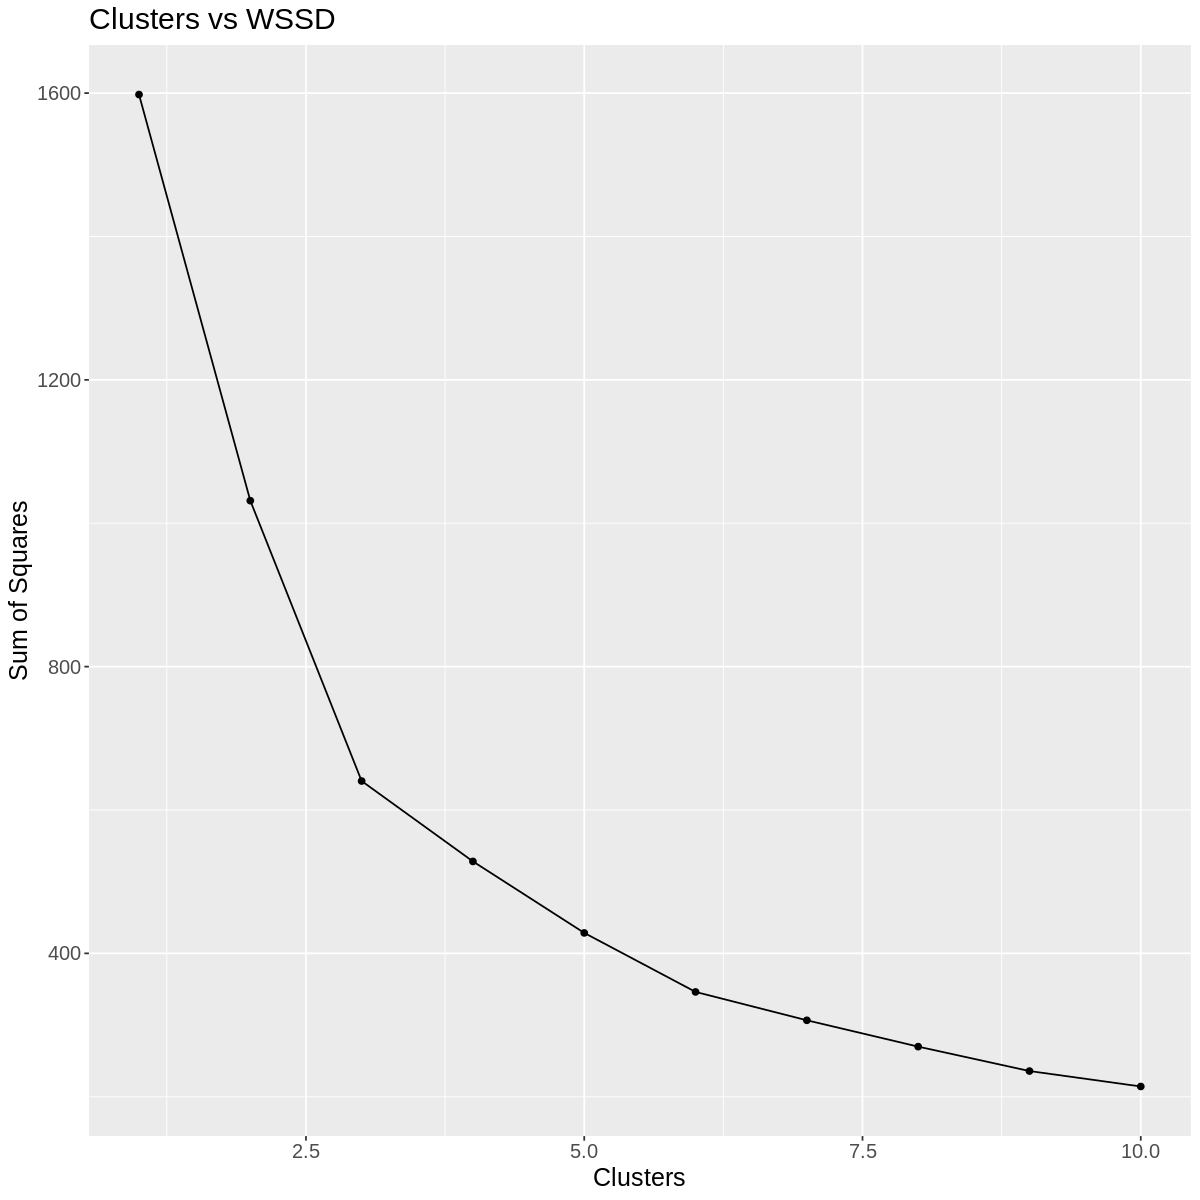

In [17]:
# your code here
options(repr.plot.width = 10, repr.plot.height = 10) 
elbow_plot <- ggplot(elbow_stats, aes(x = k, y = tot.withinss)) +
    geom_line() +
    geom_point() +
    labs(x = 'Clusters', y = 'Sum of Squares') +
    theme(text = element_text(size = 15)) +
    ggtitle('Clusters vs WSSD')

elbow_plot

In [18]:
test_1.8()

Test passed 😸
Test passed 🌈
Test passed 🎉
Test passed 🥳
Test passed 🌈
[1] "Success!"


**Question 1.9** 
<br> {points: 3}

Based on the elbow plot above, what value of $k$ do you choose? Explain why.

Based on the plot above, I choose 3 as the value of k. This is because 3 is the elbow of this plot. The rate of decrease in WSSD, as represented by the slope, for k = 1 and k = 2 are very large, but for k = 3, it decreases signficantly. For k = 3 and all larger values of k, the rate of decraese in WSSD remains relatively the same, and so 3 is the optimal k value.

**Question 1.10**
<br> {points: 3}

Using the value that you chose for k, perform the k-means algorithm, set `nstart = 10` and assign your answer to an object called `pokemon_final_kmeans`. 

Augment the data with the final cluster labels and assign your answer to an object called `pokemon_final_clusters`. 

Finally, create a plot called `pokemon_final_clusters_plot` to visualize the clusters. Include a title, colour the points by the cluster and make sure your axes are human-readable.

Speed,Defense,.cluster
"<dbl[,1]>","<dbl[,1]>",<fct>
-0.8010021,-0.7966553,1
-0.2848371,-0.3476999,1
0.4033830,0.2936649,2
⋮,⋮,⋮
0.05927295,-0.4439046,1
0.40338296,-0.4439046,2
0.05927295,1.4801898,3


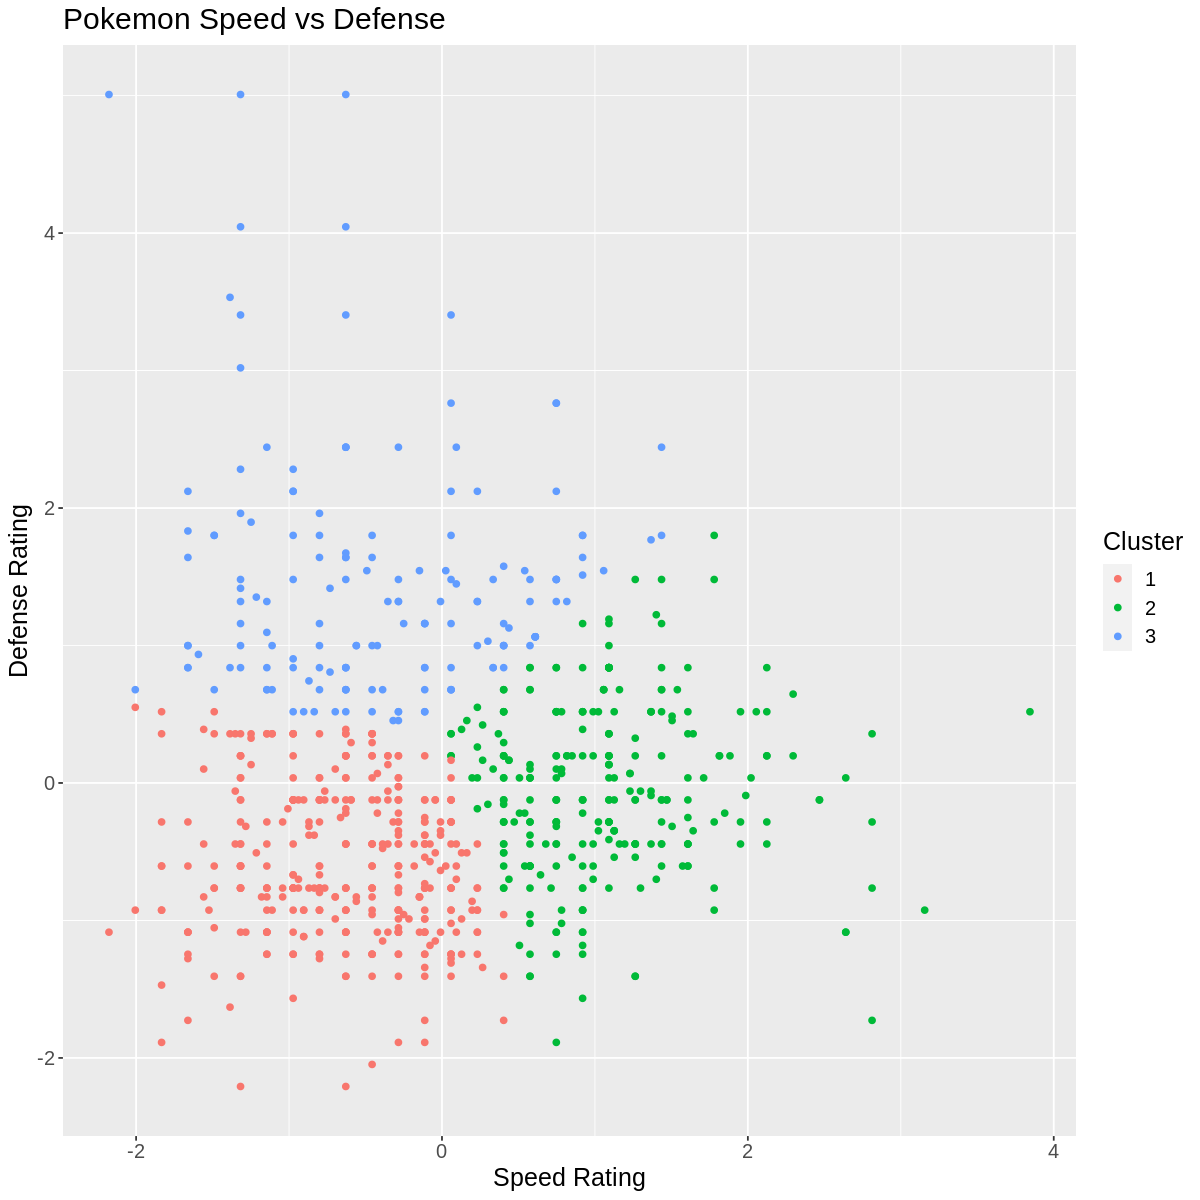

In [19]:
set.seed(2019) # DO NOT REMOVE
# your code here
pokemon_final_kmeans <- kmeans(scaled_km_data, centers = 3, nstart = 10)
pokemon_final_clusters <- augment(pokemon_final_kmeans, scaled_km_data)
pokemon_final_clusters

options(repr.plot.width = 10, repr.plot.height = 10) 
pokemon_final_clusters_plot <- ggplot(pokemon_final_clusters, aes(x = Speed, y = Defense, colour = .cluster)) +
    geom_point() +
    labs(x = 'Speed Rating', y = 'Defense Rating', colour = 'Cluster') +
    theme(text = element_text(size = 15)) +
    ggtitle('Pokemon Speed vs Defense')
pokemon_final_clusters_plot

**Question 1.11**
<br> {points: 3}

Using `Speed` and `Defense`, we find some number of clusters in our data. However, we have more information in our dataset that might be useful for clustering. Let's incorporate all of the numeric values to our k-means model. Again use `nstart = 10`.

Your tasks:

1. Select the numeric type columns only from the full data set `pm_data`. For example, do not include the `#` or `Generation`  columns etc. Assign your answer to an object called `pm_multi`.
2. Standardize the columns in `pm_multi` using `scale`.
2. From K = 1 to K = 10, calculate the total within-cluster sum of squares. Set `nstart` to be 10. Assign your answer to an object called `pm_multi_elbow_stats`. 
3. Use the elbow plot method to determine the number of clusters. Assign your answer to an object called `pm_multi_elbow_plot`.
4. Train a k-means model with the number of clusters determined in above. Assign your answer to an object called `multi_kmeans`. 
5. Print the cluster means for the trained model.

k,totss,tot.withinss,betweenss,iter
<int>,<dbl>,<dbl>,<dbl>,<int>
1,5593,5593.000,2.273737e-11,1
2,5593,3511.094,2.081906e+03,1
3,5593,3032.759,2.560241e+03,3
⋮,⋮,⋮,⋮,⋮
8,5593,2068.811,3524.189,6
9,5593,1958.323,3634.677,5
10,5593,1865.294,3727.706,6


K-means clustering with 2 clusters of sizes 378, 422

Cluster means:
       Total         HP     Attack    Defense    Sp. Atk    Sp. Def      Speed
1 -0.8838645 -0.5879347 -0.6374233 -0.5558041 -0.6170218 -0.6599417 -0.4969472
2  0.7917080  0.5266335  0.5709621  0.4978530  0.5526878  0.5911326  0.4451328

Clustering vector:
  [1] 1 1 2 2 1 1 2 2 2 1 1 2 2 1 1 1 1 1 1 2 1 1 2 2 1 1 1 2 1 2 1 2 1 2 1 1 2
 [38] 1 1 2 1 2 1 2 1 2 1 2 1 1 2 1 1 1 2 1 1 1 2 1 2 1 2 1 2 1 1 2 1 1 2 2 1 1
 [75] 2 1 1 2 1 2 1 1 2 1 2 1 2 2 1 2 1 1 2 1 2 1 2 1 2 1 1 2 2 1 1 2 1 2 1 2 1
[112] 2 1 1 2 2 1 1 2 1 2 2 1 2 2 1 2 1 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 1 1 2 2 2
[149] 1 1 2 1 2 2 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 1 1 2 1 1 2 1 1 1 2 1 1 1 1 2 1
[186] 2 1 1 1 1 1 1 2 1 1 2 2 2 1 1 1 2 1 1 2 1 1 2 1 1 2 2 2 1 2 2 1 1 2 1 2 1
[223] 1 2 2 1 2 1 2 2 2 2 2 1 1 2 1 1 1 2 1 1 2 1 2 2 1 2 2 2 1 2 2 2 1 1 2 1 1
[260] 1 2 2 2 2 2 1 1 2 2 2 2 2 1 1 2 2 1 1 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2
[297] 1 1 2 1 1 1 1 1 1 2 2 1 1 1 

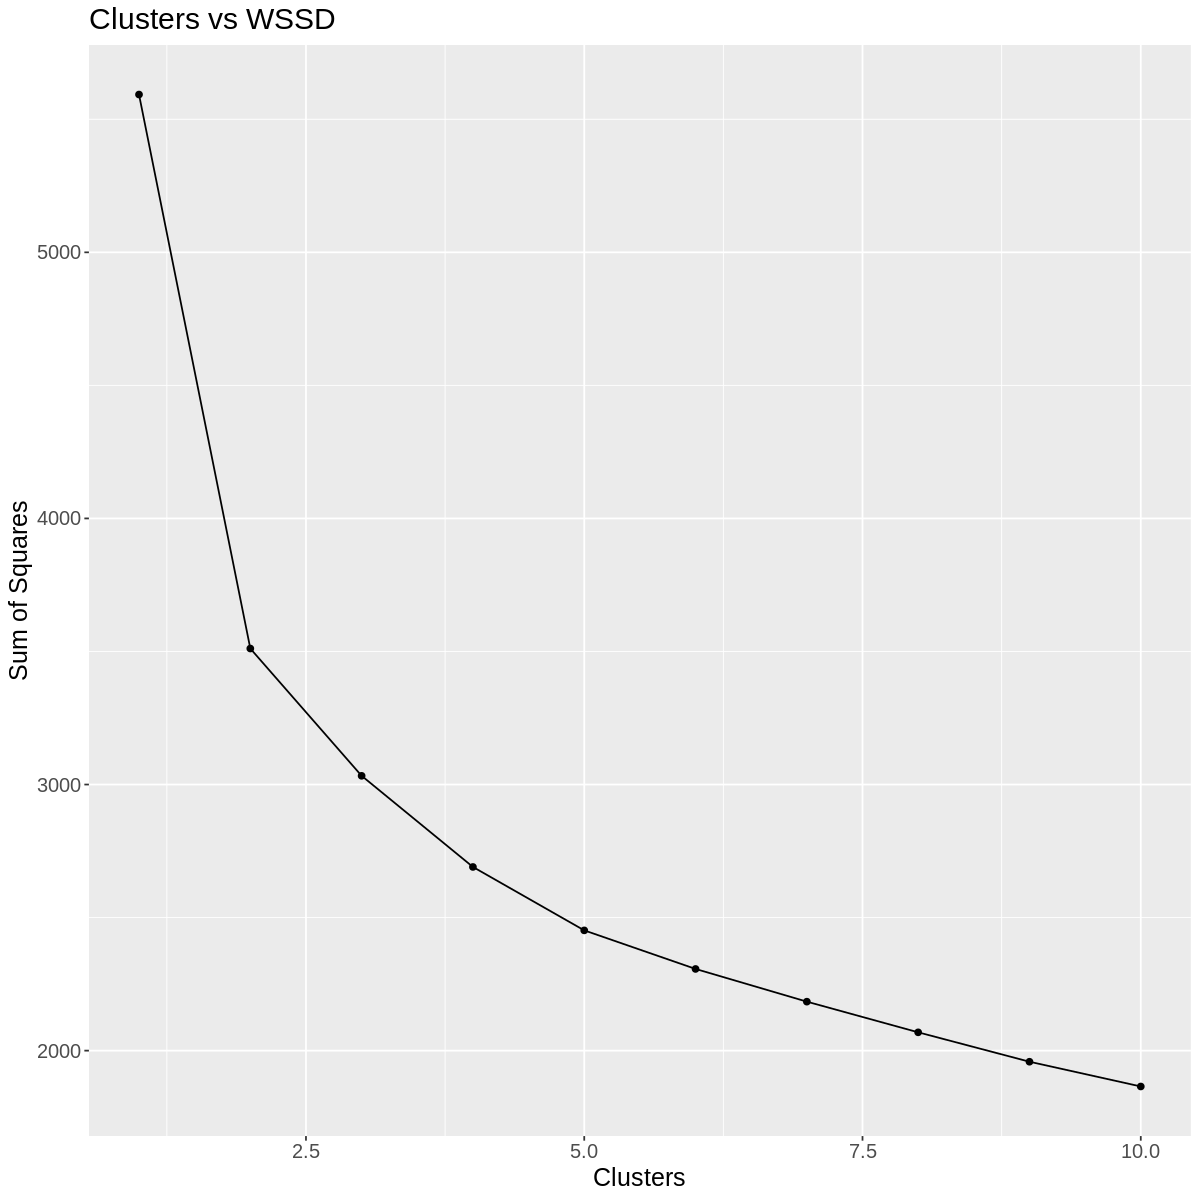

In [20]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

# your code here
pm_multi <- pm_data |> select("Total", "HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed") |>
    map_df(scale)

pm_multi_elbow_stats <- tibble(k = seq(1:10)) |>
               rowwise() |>
               mutate(poke_clusts = list(kmeans(pm_multi, centers = k, nstart = 10))) |>
               mutate(glanced = list(glance(poke_clusts))) |>
               select(-poke_clusts) |>
               unnest(glanced)
pm_multi_elbow_stats

pm_multi_elbow_plot <- ggplot(pm_multi_elbow_stats, aes(x = k, y = tot.withinss)) +
    geom_line() +
    geom_point() +
    labs(x = 'Clusters', y = 'Sum of Squares') +
    theme(text = element_text(size = 15)) +
    ggtitle('Clusters vs WSSD')
pm_multi_elbow_plot

multi_kmeans <- kmeans(pm_multi, centers = 2, nstart = 10)
multi_kmeans

**Question 1.12** 
<br> {points: 3}

Visualizing these clusters is not a simple task given the high-dimensionality of the model. But do the cluster means output help? Justify your reasoning.

The cluster means output does help, as it still contains a lot of information to help us evaluate the clusters. For example, we can augment the output which gives a table with all the coordinate values of the points as well as their cluster. While this isn't as good as visualizing the clusters, it is still useful.

# 2. Tourism Reviews

![](https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif)
Source: https://media.giphy.com/media/xUNd9IsOQ4BSZPfnLG/giphy.gif

The Ministry of Land, Infrastructure, Transport and Tourism of Japan is interested in knowing the type of tourists that visit East Asia. They know the [majority of their visitors come from this region](https://statistics.jnto.go.jp/en/graph/) and would like to stay competitive in the region to keep growing the tourism industry. For this, they have hired us to perform segmentation of the tourists. A [dataset from TripAdvisor](https://archive.ics.uci.edu/ml/datasets/Travel+Reviews) has been scraped and it's provided to you.

This dataset contains the following variables:

- User ID : Unique user id 
- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

**Question 2.0**
<br> {points: 3}

Load the data set from https://archive.ics.uci.edu/ml/machine-learning-databases/00484/tripadvisor_review.csv and clean it so that only the Category # columns are in the data frame (i.e., remove the `User ID` column). 

Assign your answer to an object called `clean_reviews`.

In [27]:
# your code here
reviews <- read_csv("data/tripadvisor_review.csv")
clean_reviews <- reviews |>
    select(-"User ID")
clean_reviews

Rows: 980 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): User ID
dbl (10): Category 1, Category 2, Category 3, Category 4, Category 5, Catego...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Category 1,Category 2,Category 3,Category 4,Category 5,Category 6,Category 7,Category 8,Category 9,Category 10
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.93,1.8,2.29,0.62,0.80,2.42,3.19,2.79,1.82,2.42
1.02,2.2,2.66,0.64,1.42,3.18,3.21,2.63,1.86,2.32
1.22,0.8,0.54,0.53,0.24,1.54,3.18,2.80,1.31,2.50
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.61,1.32,0.67,0.43,1.30,1.78,3.17,2.81,1.34,3.02
0.93,0.20,0.13,0.43,0.30,0.40,3.18,2.98,1.12,2.46
0.93,0.56,1.13,0.51,1.34,2.36,3.18,2.87,1.34,2.40


In [28]:
test_that('Did not create an object called clean_reviews', {
    expect_true(exists("clean_reviews"))
})
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.


Test passed 🎊


**Question 2.1**
<br> {points: 3}

Perform k-means and vary $k$ from 1 to 10 to identify the optimal number of clusters. Use `nstart = 100`. Assign your answer to a tibble object called `elbow_stats` that has the columns `k`, `totss`, `tot.withinss`, `betweenss`, and `iter`.  

Afterwards, create an elbow plot to help you choose $k$. Assign your answer to an object called `tourism_elbow_plot`.

Warning message:
“did not converge in 10 iterations”


k,totss,tot.withinss,betweenss,iter
<int>,<dbl>,<dbl>,<dbl>,<int>
1,1736.187,1736.187,1.818989e-11,1
2,1736.187,1179.753,5.564334e+02,1
3,1736.187,1052.361,6.838255e+02,3
⋮,⋮,⋮,⋮,⋮
8,1736.187,750.2073,985.9795,4
9,1736.187,716.3485,1019.8383,5
10,1736.187,686.5634,1049.6234,7


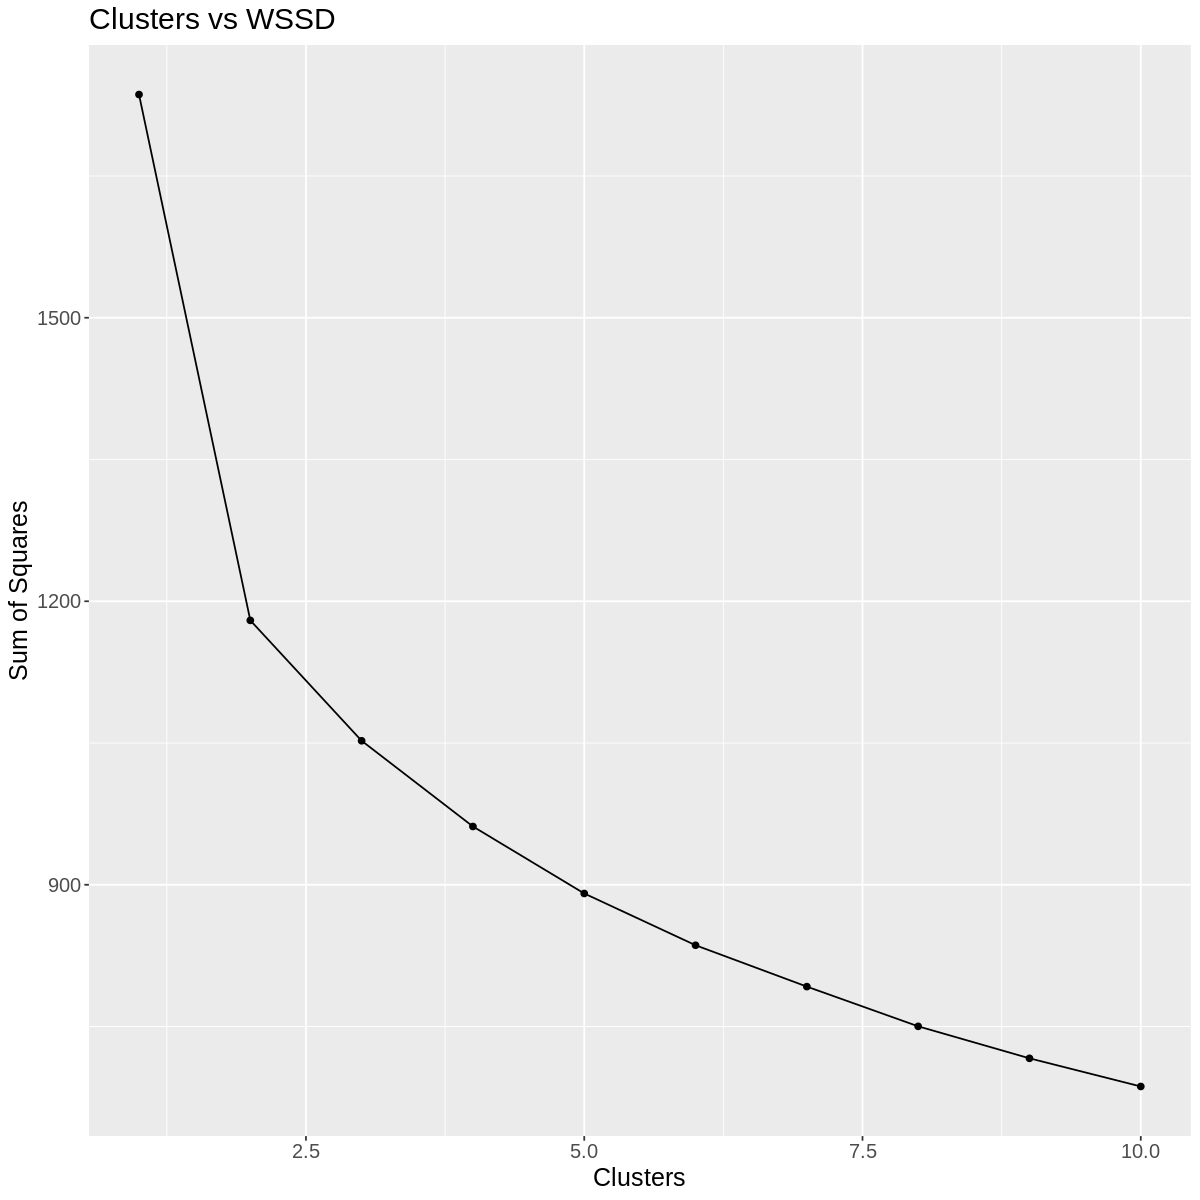

In [31]:
#DON'T CHANGE THIS SEED VALUE
set.seed(2019)

# your code here
elbow_stats <- tibble(k = seq(1:10)) |>
               rowwise() |>
               mutate(clean_clusts = list(kmeans(clean_reviews, k, nstart = 100))) |>
               mutate(glanced = list(glance(clean_clusts))) |>
               select(-clean_clusts) |>
               unnest(glanced)
elbow_stats

tourism_elbow_plot <- ggplot(elbow_stats, aes(x = k, y = tot.withinss)) +
    geom_line() +
    geom_point() +
    labs(x = 'Clusters', y = 'Sum of Squares') +
    theme(text = element_text(size = 15)) +
    ggtitle('Clusters vs WSSD')
tourism_elbow_plot

In [32]:
test_that('Did not create an object called elbow_stats', {
    expect_true(exists('elbow_stats'))
})
test_that('Did not create a plot called tourism_elbow_plot', {
    expect_true(exists('tourism_elbow_plot'))
})
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.

Test passed 😀
Test passed 🎉


**Question 2.2** 
<br> {points: 3}

From the elbow plot above, which $k$ should you choose? Explain why you chose that $k$.

From the plot above, the optimal k is 2. This is because 2 is the elbow of the plot, meaning that any k greater than 2 still does decrease WSSD, but only by a diminishing amount. Any k smaller than 2 has a very large WSSD, and so the middle point between the large decrease in WSSD and diminishing decrease in WSSD is the optimal k value.

**Question 2.3**
<br> {points: 3}

Run kmeans again, with the optimal $k$, and assign your answer to an object called `reviews_clusters`. Use `nstart = 100`. Then, use the `augment` function to get the cluster assignments for each point. Name the data frame `cluster_assignments`.

In [33]:
#DONT CHANGE THIS SEED VALUE
set.seed(2019)

# your code here
reviews_clusters <- kmeans(clean_reviews, centers = 2, nstart = 100)
cluster_assignments <- augment(reviews_clusters, clean_reviews)
reviews_clusters

K-means clustering with 2 clusters of sizes 598, 382

Cluster means:
  Category 1 Category 2 Category 3 Category 4 Category 5 Category 6 Category 7
1  0.8850167   1.309900   0.491990  0.5003679  0.7862542   1.625284   3.176973
2  0.9059948   1.419476   1.829398  0.5828010  1.1800000   2.183560   3.187147
  Category 8 Category 9 Category 10
1   2.854331   1.597124    2.925485
2   2.804895   1.526099    2.601571

Clustering vector:
  [1] 2 2 1 1 2 1 1 1 2 1 2 1 2 2 2 2 1 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 2 1 1 1 1
 [38] 1 2 1 1 1 1 1 1 1 1 1 1 2 1 2 2 1 1 1 2 1 2 2 2 1 1 1 1 1 2 1 2 1 1 2 1 2
 [75] 2 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 2 2 2 1 1 1 2 1 1 2 2 1 1 2 1
[112] 2 1 2 2 1 2 1 1 1 2 1 2 1 2 1 1 1 1 1 2 2 2 2 1 1 2 2 1 1 1 1 1 1 1 1 1 2
[149] 1 2 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2
[186] 1 1 1 2 1 2 2 1 1 1 1 1 2 1 1 2 1 2 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 2 2 1 1
[223] 2 1 2 1 1 2 1 2 1 2 1 1 1 1 2 1 2 1 2 2 1 1 1 1 1 2 1 1 2 1 2 2 1 1 1 1 1
[260] 

For the following 2 questions use the following plot as reference. 

> The visualization below is a density plot, you can think of it as a smoothed version of a histogram. Density plots are more effective for comparing multiple distributions. What we are looking for with these visualizations, is to see which variables have difference distributions between the different clusters.

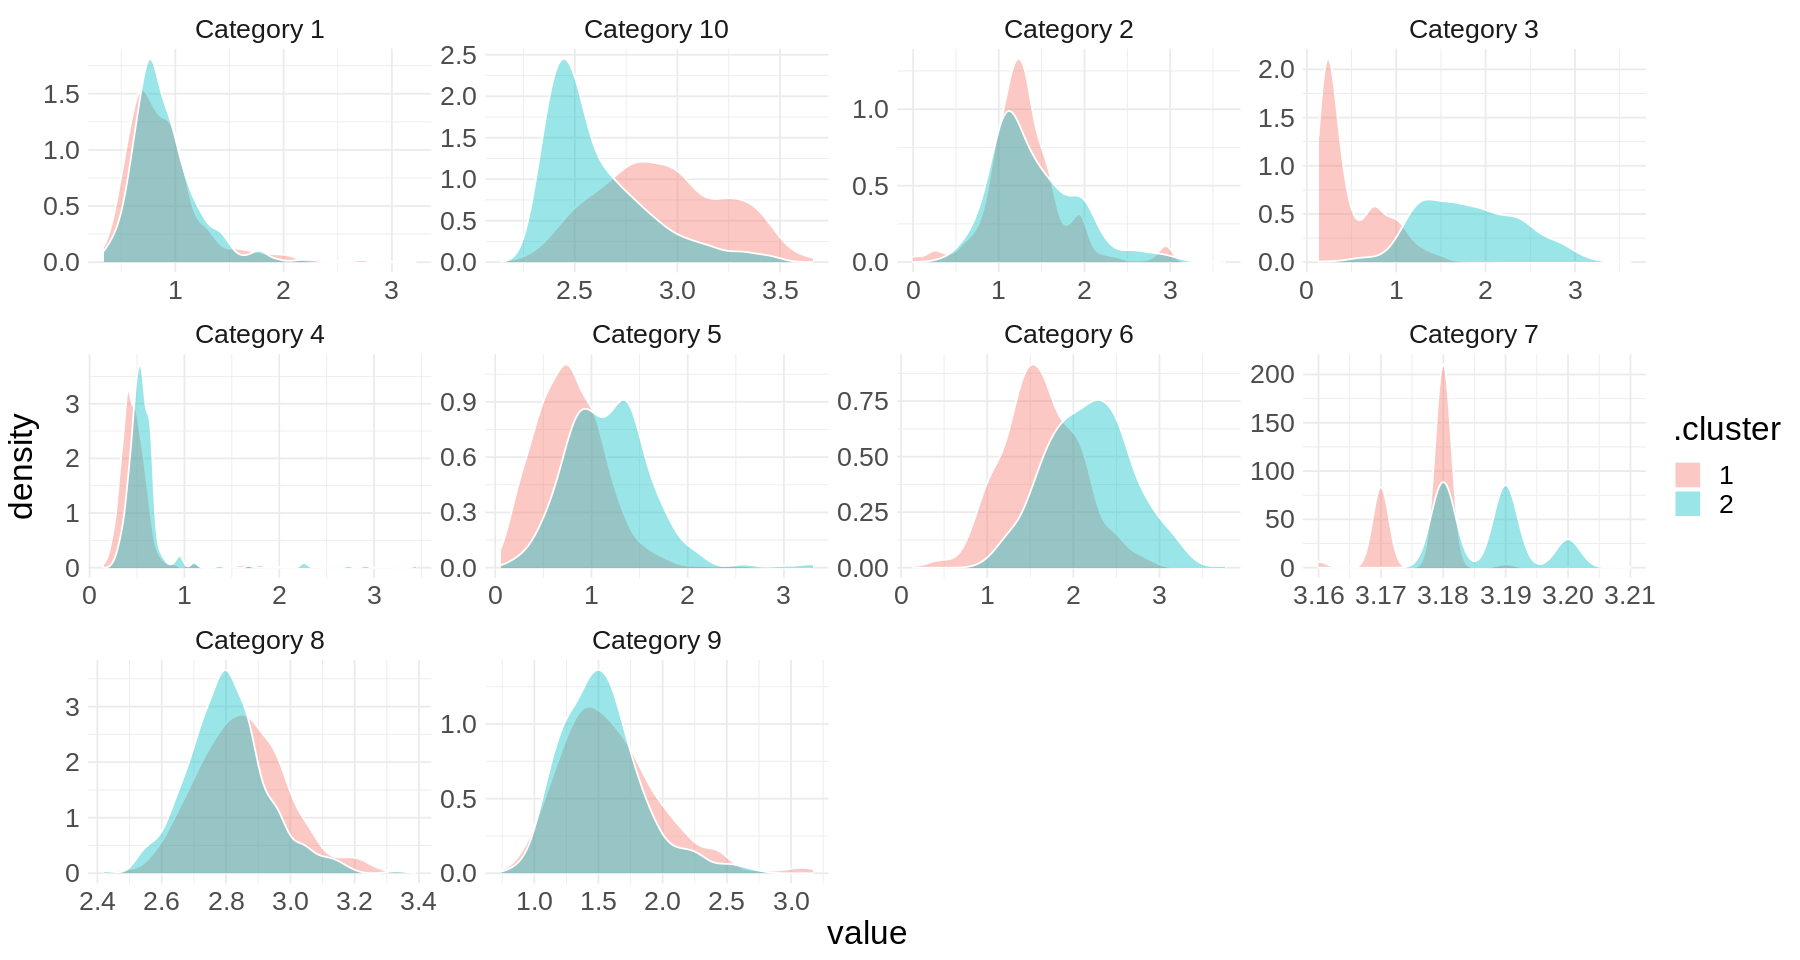

In [34]:
options(repr.plot.height = 8, repr.plot.width = 15)
cluster_assignments |>
    pivot_longer(cols = -.cluster, names_to = 'category', values_to = 'value')  |> 
    ggplot(aes(value, fill = .cluster)) +
        geom_density(alpha = 0.4, colour = 'white') +
        facet_wrap(~ category, scales = 'free') +
        theme_minimal() +
        theme(text = element_text(size = 20))

**Question 2.4** Multiple Choice:
<br> {points: 1}

From the plots above, point out the categories that we might hypothesize are driving the clustering? (i.e., are useful to distinguish between the type of tourists?) We list the table of the categories below. 

- Category 1 : Average user feedback on art galleries 
- Category 2 : Average user feedback on dance clubs 
- Category 3 : Average user feedback on juice bars 
- Category 4 : Average user feedback on restaurants 
- Category 5 : Average user feedback on museums 
- Category 6 : Average user feedback on resorts 
- Category 7 : Average user feedback on parks/picnic spots 
- Category 8 : Average user feedback on beaches 
- Category 9 : Average user feedback on theaters 
- Category 10 : Average user feedback on religious institutions

A. 10, 3, 5, 6, 7

B. 10, 3, 5, 6, 1

C. 10, 3, 4, 6, 7

D. 10, 2, 5, 6, 7

*Assign your answer to an object called `answer2.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [35]:
# your code here
answer2.4 <- "A"
answer2.4

[1] "A"

In [36]:
test_that('Did not create an object called answer2.4', {
    expect_true(exists('answer2.4'))
    })
# The remainder of the tests were intentionally hidden so that you can practice deciding 
# when you have the correct answer.


Test passed 😀


**Question 2.5** 
<br> {points: 3}

Discuss one disadvantage of not being able to visualize the clusters when dealing with multidimensional data.

It is much easier to interpret the clusters when they are visualized, both how accurate the algorithm is, as well as what each cluster is referring to. For example, with a visualization, it is much easier to see that cluster 1 groups together tourists with high ratings in the first five categories and low ratings in the second five, as opposed to figuring out that information from a table.

In [ ]:
source("cleanup.R")